<html>
    <body>
    <h1 style="color:#483D8B;text-align:center;">Sensitivity Analysis</h1> 
    <h2 style="color:#483D8B;text-align:center;">A human intracellular core metabolic pathway in a red blood cell</h2>
    <br>7 June 2021 @ unibg
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    <h3 style="color:#483D8B;">Andrea Tangherloni, PhD</h3><br>
    Senior Postdoc – University of Bergamo<br>
    Department of Human and Social Sciences<br>
    <br>
    <em>
        <span style="color:#483D8B;"><b>Address:</b></span> Piazzale S. Agostino 2,<br>
        24129, Bergamo, Italy<br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:andrea.tangherloni@unibg.it">andrea.tangherloni@unibg.it</a> <br>
        <span style="color:#483D8B;"><b>Website:</b></span>
            <a href="https://www.andreatangherloni.com">www.andreatangherloni.com</a> <br>
    </em>
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    <h3 style="color:#483D8B;">Marco S. Nobile, PhD</h3><br>
    Assistant Professor – Eindhoven University of Technology<br>
    Department of Industrial Engineering & Innovation Sciences<br>
    <br>
    <em>
        <span style="color:#483D8B;"><b>Address:</b></span> De Zaale <br>
        5612 AZ, Eindhoven, The Netherlands<br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:m.s.nobile@tue.nl">m.s.nobile@tue.nl</a> <br>
        <span style="color:#483D8B;"><b>Website:</b></span>
            <a href="https://www.msnobile.it">www.www.msnobile.it</a> <br>
    </em>
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    </body>
</html>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

In [2]:
import glob,os,shutil
import numpy as np
import random as rnd
import pandas as pd

from subprocess import *
from math import *
from random import randint
from SALib.sample import saltelli
from SALib.analyze import sobol, morris
from matplotlib import pyplot as plt

We perform here a Sensitivity Analysis (SA) of the model presented in the paper entitled <a href="https://link.springer.com/chapter/10.1007/978-3-030-34585-3_17">_"Efficient and settings-free calibration of detailed kinetic metabolic models with enzyme isoforms characterization"_</a>.

The basic version of this reaction-based model (RBM) consists of 92 metabolites and 94 reactions describing the central pathways for carbohydrate metabolism, namely, glycolysis and pentose phosphate pathway, in a human red blood cell. 
Here, we do not consider the uptake of extracellular substrates but we consider the different isoforms of the enzyme hexokinase (HK), the first enzyme of the glycolythic pathway that converts glucose (GLC) into glucose-6-phosphate (G6P).
In such a way, we were able to extend the RBM obtaining 226 reactions among 114 species.

# Generation of all the tested conditions

In such a case, the SA is performed by varying the initial concentration of the HK isoform with the highest abundance. Specifically, we modify all the initial concentrations of all the intermediate chemical complexes produced from this HK isoform.

We sample the initial concentration of these species in the range [0, 1e-5].

In [3]:
def generateConditions(pathModel, num_samples=32, minCon=0, maxConc=1e-5):
    
    c_vector = np.loadtxt(pathModel+os.sep+"c_vectorBase")
    M_0      = np.loadtxt(pathModel+os.sep+"M_0Base")
    species  = np.loadtxt(pathModel+os.sep+"alphabet", dtype='str')
    binary   = [True if "_2" in s else False for s in species]
    
    filtered = species[binary]  
    
    print(" * Sampling for the species:", "|".join(filtered))
    
    boundaries = [[minCon, maxConc]]*len(filtered)

    problem = {'num_vars' : len(filtered),
               'names' : [ '%s' % n for n in filtered],
               'bounds' : boundaries}
    
    # Generate num_samples∗(num_vars∗2+2) samples
    samples = saltelli.sample(problem, num_samples, calc_second_order=True)
    
    MX_0 = np.tile(M_0,(len(samples),1))
            
    indices = np.where(binary)[0]
    for i,sample in enumerate(samples):
        for s,j in enumerate(indices):
            MX_0[i][j] = sample[s]
            
    c_matrix = np.array([c_vector]*len(samples))
    
    np.savetxt(pathModel+os.sep+"c_matrixTot", c_matrix, delimiter="\t")
    np.savetxt(pathModel+os.sep+"MX_0Tot", MX_0, delimiter="\t")
    
    return c_matrix, MX_0, problem

# Call FiCoS

The required simulations can be divided into different batches.
Each batch is composed of different simulations (parameterizations of the model) which are executed in parallel by FiCoS.

In [4]:
def runFiCoS(binary_ficos, model, out_dir, c_matrixTot, MX_0Tot, numParalSim=32):
    
    steps = len(MX_0Tot)//numParalSim+1
    
    integrationTime = 0
    simulationTime  = 0
    
    print("\n * Running FiCoS")
    for i in range(1, steps+1):
        # saving the files needed for the simulations
        np.savetxt(model+os.sep+"c_matrix", c_matrixTot[(i-1)*numParalSim:i*numParalSim, :], delimiter="\t")
        np.savetxt(model+os.sep+"MX_0",     MX_0Tot[(i-1)*numParalSim:i*numParalSim, :], delimiter="\t")
        
        step = MX_0Tot[(i-1)*numParalSim:i*numParalSim, :].shape[0]
        
        if (i-1)*numParalSim == len(MX_0Tot):
            break
        
        print(" \t * running simulations from %5d to %5d"%((i-1)*numParalSim, (i-1)*numParalSim+step-1))
        
        # call FiCoS
        fullcall  = [binary_ficos,
                     model,
                     out_dir+os.sep+"sims_%d"%((i-1)*numParalSim)
                    ]

        risultato = check_output(fullcall)
        risultato = risultato.split()

        integrationTime += float(risultato[3])
        simulationTime  += float(risultato[6])

    print("*"*100)
    print("\n * Integration time %5.2fs - simulation time %5.2fs"%(integrationTime, simulationTime))
    print("*"*100)
    
    return integrationTime, simulationTime

# Call LSODA

In [5]:
def runLSODA(binary_lsoda, model, out_dir, MX_0Tot, maxTime):
        
    integrationTime = 0
    simulationTime  = 0
    
    print("\n * Running LSODA")
    for sim,M_0 in enumerate(MX_0Tot):

        np.savetxt(model+os.sep+"M_0", [M_0], delimiter="\t")

        print(" \t * Running simulation %3d out of %3d"%(sim, len(MX_0Tot)))

        # call LSODA
        fullcall  = ["python",
                     binary_lsoda,
                     model,
                     out_dir+os.sep+"out_%d"%(sim),
                     "-l"]

        risultato = check_output(fullcall)
        risultato = risultato.split()

        integrationTime += float(risultato[8])
        simulationTime  += float(risultato[11])
        
        if simulationTime >= maxTime:
            print("*"*100)
            print("\n * Integration time %5.2fs - simulation time %5.2fs"%(integrationTime, simulationTime))
            print("*"*100)
            return integrationTime, simulationTime, sim

# Running the simulations with FiCoS and LSODA

In [6]:
binary_ficos = "./../FiCoS_gpu"
binary_lsoda = ".."+os.sep+"Simulators"+os.sep+"simulator.py"
model        = ".."+os.sep+"Models"+os.sep+"HumanMetabolicPathway"
numParalSim  = 512
num_samples  = 512
out_dir      = "resultsSA"

print("*"*100)
print(" * Generating SA conditions ...")
c_matrixTot, MX_0Tot, problem = generateConditions(model, num_samples=num_samples)
print(" * %d SA conditions genereted"%len(MX_0Tot))
print ("*"*100)


if not os.path.exists(out_dir):
    os.makedirs(out_dir)

shutil.copy(model+os.sep+"c_matrixTot", out_dir+os.sep+"c_matrixTot")
shutil.copy(model+os.sep+"MX_0Tot",     out_dir+os.sep+"MX_0Tot")

integrationTimeFiCoS, simulationTimeFiCoS         = runFiCoS(binary_ficos, model, out_dir, c_matrixTot, MX_0Tot, numParalSim=numParalSim)
integrationTimeLSODA, simulationTimeLSODA, n_sims = runLSODA(binary_lsoda, model, out_dir, MX_0Tot, simulationTimeFiCoS)
print()
print(" * Achieved speed-up wrt LSODA %3.2fx"%(len(MX_0Tot)/n_sims))

****************************************************************************************************
 * Generating SA conditions ...
 * Sampling for the species: hkE_2|hkEMgATP_2|hkEMgATPGLC_2|hkEGLC_2|hkEMgADPG6P_2|hkEG6P_2|hkEMgADP_2|hkEGLCGSH_2|hkEGLCDPG23_2|hkEPhosi_2|hkEGLCG6P_2
 * 12288 SA conditions genereted
****************************************************************************************************

 * Running FiCoS
 	 * running simulations from     0 to   511
 	 * running simulations from   512 to  1023
 	 * running simulations from  1024 to  1535
 	 * running simulations from  1536 to  2047
 	 * running simulations from  2048 to  2559
 	 * running simulations from  2560 to  3071
 	 * running simulations from  3072 to  3583
 	 * running simulations from  3584 to  4095
 	 * running simulations from  4096 to  4607
 	 * running simulations from  4608 to  5119
 	 * running simulations from  5120 to  5631
 	 * running simulations from  5632 to  6143
 	 * running simulation

# Performing the Sensitivity Analysis (SA)

In [6]:
binary_ficos = "./../FiCoS_gpu"
binary_lsoda = ".."+os.sep+"Simulators"+os.sep+"simulator.py"
model        = ".."+os.sep+"Models"+os.sep+"HumanMetabolicPathway"
numParalSim  = 512
num_samples  = 512
out_dir      = "resultsSA"

print("*"*100)
print(" * Generating SA conditions ...")
c_matrixTot, MX_0Tot, problem = generateConditions(model, num_samples=num_samples)
print(" * %d SA conditions genereted"%len(MX_0Tot))
print ("*"*100)

****************************************************************************************************
 * Generating SA conditions ...
 * Sampling for the species: hkE_2|hkEMgATP_2|hkEMgATPGLC_2|hkEGLC_2|hkEMgADPG6P_2|hkEG6P_2|hkEMgADP_2|hkEGLCGSH_2|hkEGLCDPG23_2|hkEPhosi_2|hkEGLCG6P_2
 * 12288 SA conditions genereted
****************************************************************************************************


In [7]:
all_species   = np.loadtxt(model+os.sep+"alphabet", dtype='str')
saved_species = np.loadtxt(model+os.sep+"cs_vector", dtype=int)

binary   = [True if "_2" in s else False for s in all_species]
filtered = all_species[binary] 

In [8]:
baseline = np.loadtxt(model+os.sep+"Solution")

## Calculating the differences |baseline[-1] - dynamics[-1]|

In [9]:
print("* Calculating differences for the species %s"%all_species[saved_species])

differences = {}
for idx,s in enumerate(all_species[saved_species]):
    differences[s] = list()

for folder in sorted(glob.glob(out_dir+os.sep+'sims_*')):
    for sim in range(numParalSim):
        file = folder+os.sep+"Solution%d"%sim
        if os.path.isfile(file):
            dynamics = np.loadtxt(file)
            for idx,s in enumerate(all_species[saved_species]):
                differences[s] += [abs(baseline[:,idx+1][-1]- dynamics[:,idx+1][-1])]

* Calculating differences for the species ['GLC' 'G6P' 'FDP' 'GAP' 'PYR' 'LAC' 'GL6P' 'R5P']


## SA of the GLC species

In [10]:
SI = sobol.analyze(problem, np.array(differences['GLC']), print_to_console=False)

In [13]:
SI_filter = {k:SI[k] for k in ['ST','ST_conf','S1','S1_conf']}
SI_df     = pd.DataFrame(SI_filter, index=problem['names'])
SI_df

ST   ST_conf        S1   S1_conf
hkE_2          0.139186  0.019441 -0.005162  0.048587
hkEMgATP_2     0.139424  0.019455  0.015467  0.047949
hkEMgATPGLC_2  0.139595  0.018765  0.009081  0.046703
hkEGLC_2       0.147964  0.025769  0.043000  0.049447
hkEMgADPG6P_2  0.145825  0.023599  0.030981  0.048628
hkEG6P_2       0.152452  0.027480 -0.009277  0.048758
hkEMgADP_2     0.111803  0.022773  0.031850  0.039710
hkEGLCGSH_2    0.488119  0.082760  0.195300  0.082890
hkEGLCDPG23_2  0.463577  0.068069  0.236839  0.079350
hkEPhosi_2     0.509511  0.086445  0.229693  0.086809
hkEGLCG6P_2    0.484375  0.084839  0.210259  0.084668

In [17]:
fig, ax = plt.subplots(1)

indices = SI_df[['S1','ST']]
err = SI_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,4)

plt.show()

## SA of the G6P species

In [10]:
SI = sobol.analyze(problem, np.array(differences['G6P']), print_to_console=False)

In [11]:
SI_filter = {k:SI[k] for k in ['ST','ST_conf','S1','S1_conf']}
SI_df     = pd.DataFrame(SI_filter, index=problem['names'])
SI_df

ST   ST_conf        S1   S1_conf
hkE_2          0.138071  0.020476 -0.005054  0.046570
hkEMgATP_2     0.139219  0.018383  0.015528  0.043286
hkEMgATPGLC_2  0.139304  0.019465  0.008284  0.048610
hkEGLC_2       0.148317  0.023046  0.041862  0.047725
hkEMgADPG6P_2  0.145346  0.019620  0.031265  0.044533
hkEG6P_2       0.152898  0.022952 -0.009464  0.048593
hkEMgADP_2     0.111822  0.019619  0.029856  0.041279
hkEGLCGSH_2    0.487220  0.075678  0.198287  0.085439
hkEGLCDPG23_2  0.462531  0.071327  0.239419  0.083104
hkEPhosi_2     0.509019  0.079130  0.232224  0.089759
hkEGLCG6P_2    0.482756  0.080757  0.211675  0.078669

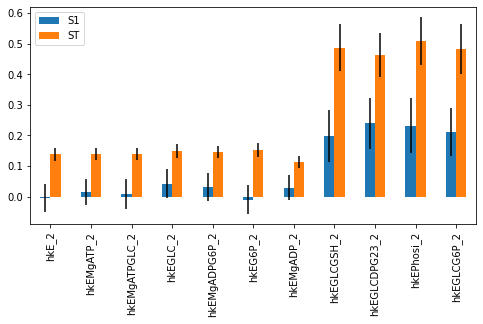

In [12]:
fig, ax = plt.subplots(1)

indices = SI_df[['S1','ST']]
err = SI_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,4)

plt.show()

## SA of the FDP species

In [13]:
SI = sobol.analyze(problem, np.array(differences['FDP']), print_to_console=False)

In [14]:
SI_filter = {k:SI[k] for k in ['ST','ST_conf','S1','S1_conf']}
SI_df     = pd.DataFrame(SI_filter, index=problem['names'])
SI_df

ST   ST_conf        S1   S1_conf
hkE_2          0.137705  0.020136 -0.005008  0.039700
hkEMgATP_2     0.139198  0.019065  0.015530  0.048036
hkEMgATPGLC_2  0.139238  0.018864  0.007949  0.051174
hkEGLC_2       0.148496  0.026364  0.041414  0.043838
hkEMgADPG6P_2  0.145201  0.026302  0.031326  0.046080
hkEG6P_2       0.153106  0.024837 -0.009509  0.042815
hkEMgADP_2     0.111845  0.020253  0.029064  0.041818
hkEGLCGSH_2    0.486919  0.084023  0.199367  0.069777
hkEGLCDPG23_2  0.462225  0.071351  0.240353  0.077233
hkEPhosi_2     0.508822  0.084623  0.233116  0.074876
hkEGLCG6P_2    0.482153  0.092359  0.212134  0.076129

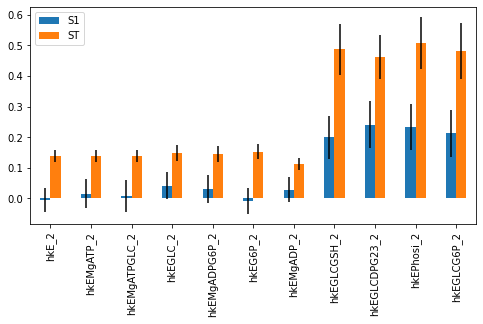

In [15]:
fig, ax = plt.subplots(1)

indices = SI_df[['S1','ST']]
err = SI_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,4)

plt.show()

## SA of the GAP species

In [16]:
SI = sobol.analyze(problem, np.array(differences['GAP']), print_to_console=False)

In [17]:
SI_filter = {k:SI[k] for k in ['ST','ST_conf','S1','S1_conf']}
SI_df     = pd.DataFrame(SI_filter, index=problem['names'])
SI_df

ST   ST_conf        S1   S1_conf
hkE_2          0.136311  0.019315 -0.004604  0.048078
hkEMgATP_2     0.140128  0.020302  0.015991  0.041496
hkEMgATPGLC_2  0.139405  0.019379  0.006256  0.042883
hkEGLC_2       0.149773  0.023440  0.038635  0.048754
hkEMgADPG6P_2  0.145129  0.019016  0.031502  0.049772
hkEG6P_2       0.154465  0.026079 -0.009399  0.045357
hkEMgADP_2     0.112622  0.020686  0.025003  0.047061
hkEGLCGSH_2    0.485757  0.081015  0.204203  0.077871
hkEGLCDPG23_2  0.461181  0.072931  0.244256  0.081219
hkEPhosi_2     0.508329  0.083613  0.237266  0.087331
hkEGLCG6P_2    0.479087  0.080084  0.213662  0.075849

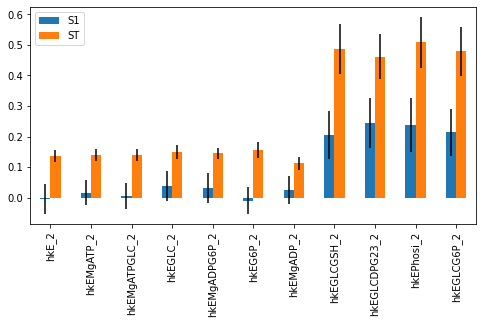

In [18]:
fig, ax = plt.subplots(1)

indices = SI_df[['S1','ST']]
err = SI_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,4)

plt.show()

## SA of the PYR species

In [19]:
SI = sobol.analyze(problem, np.array(differences['PYR']), print_to_console=False)

In [20]:
SI_filter = {k:SI[k] for k in ['ST','ST_conf','S1','S1_conf']}
SI_df     = pd.DataFrame(SI_filter, index=problem['names'])
SI_df

ST   ST_conf        S1   S1_conf
hkE_2          0.138697  0.017009 -0.005152  0.048906
hkEMgATP_2     0.139229  0.018232  0.015403  0.051427
hkEMgATPGLC_2  0.139462  0.019732  0.008712  0.053405
hkEGLC_2       0.148089  0.025818  0.042543  0.046598
hkEMgADPG6P_2  0.145574  0.023577  0.031086  0.042789
hkEG6P_2       0.152696  0.026347 -0.009368  0.049595
hkEMgADP_2     0.111730  0.023389  0.030931  0.048474
hkEGLCGSH_2    0.487721  0.077581  0.196619  0.071613
hkEGLCDPG23_2  0.463085  0.071503  0.237947  0.077673
hkEPhosi_2     0.509217  0.083455  0.230737  0.083168
hkEGLCG6P_2    0.483711  0.083705  0.210926  0.083525

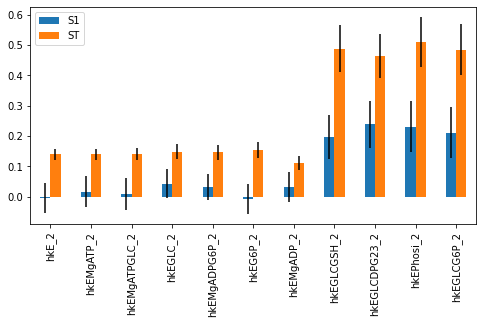

In [21]:
fig, ax = plt.subplots(1)

indices = SI_df[['S1','ST']]
err = SI_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,4)

plt.show()

## SA of the LAC species

In [22]:
SI = sobol.analyze(problem, np.array(differences['LAC']), print_to_console=False)

In [23]:
SI_filter = {k:SI[k] for k in ['ST','ST_conf','S1','S1_conf']}
SI_df     = pd.DataFrame(SI_filter, index=problem['names'])
SI_df

ST   ST_conf        S1   S1_conf
hkE_2          0.138595  0.020507 -0.005157  0.045252
hkEMgATP_2     0.139265  0.020730  0.015431  0.048934
hkEMgATPGLC_2  0.139445  0.020359  0.008653  0.051126
hkEGLC_2       0.148135  0.023888  0.042432  0.051391
hkEMgADPG6P_2  0.145555  0.022206  0.031116  0.046725
hkEG6P_2       0.152701  0.028801 -0.009413  0.056469
hkEMgADP_2     0.111774  0.021717  0.030795  0.038812
hkEGLCGSH_2    0.487635  0.078567  0.196860  0.083177
hkEGLCDPG23_2  0.463035  0.080839  0.238195  0.084689
hkEPhosi_2     0.509186  0.079638  0.230975  0.084654
hkEGLCG6P_2    0.483558  0.080253  0.211043  0.075666

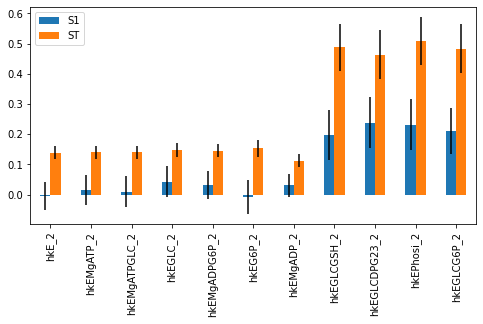

In [24]:
fig, ax = plt.subplots(1)

indices = SI_df[['S1','ST']]
err = SI_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,4)

plt.show()

## SA of the GL6P species

In [25]:
SI = sobol.analyze(problem, np.array(differences['GL6P']), print_to_console=False)

In [26]:
SI_filter = {k:SI[k] for k in ['ST','ST_conf','S1','S1_conf']}
SI_df     = pd.DataFrame(SI_filter, index=problem['names'])
SI_df

ST   ST_conf        S1   S1_conf
hkE_2          0.137939  0.019148 -0.005041  0.044330
hkEMgATP_2     0.139208  0.015729  0.015525  0.050018
hkEMgATPGLC_2  0.139278  0.019215  0.008165  0.046872
hkEGLC_2       0.148376  0.025913  0.041705  0.047267
hkEMgADPG6P_2  0.145292  0.019224  0.031286  0.042101
hkEG6P_2       0.152969  0.024413 -0.009484  0.047580
hkEMgADP_2     0.111827  0.022303  0.029577  0.041770
hkEGLCGSH_2    0.487110  0.083386  0.198672  0.083708
hkEGLCDPG23_2  0.462420  0.074118  0.239755  0.082728
hkEPhosi_2     0.508944  0.085230  0.232542  0.075724
hkEGLCG6P_2    0.482542  0.085209  0.211843  0.073997

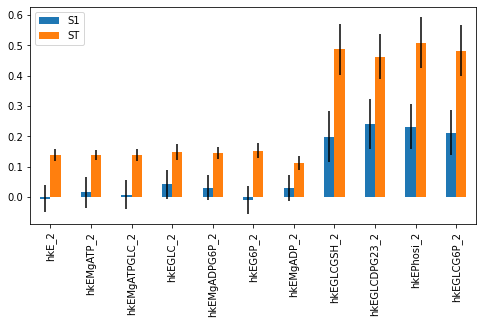

In [27]:
fig, ax = plt.subplots(1)

indices = SI_df[['S1','ST']]
err = SI_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,4)

plt.show()

## SA of the R5P species

In [28]:
SI = sobol.analyze(problem, np.array(differences['R5P']), print_to_console=False)

In [29]:
SI_filter = {k:SI[k] for k in ['ST','ST_conf','S1','S1_conf']}
SI_df     = pd.DataFrame(SI_filter, index=problem['names'])
SI_df

ST   ST_conf        S1   S1_conf
hkE_2          0.137740  0.020170 -0.005024  0.045925
hkEMgATP_2     0.139199  0.019405  0.015500  0.052106
hkEMgATPGLC_2  0.139240  0.018918  0.007950  0.053151
hkEGLC_2       0.148475  0.024537  0.041453  0.050664
hkEMgADPG6P_2  0.145204  0.022791  0.031303  0.046373
hkEG6P_2       0.153085  0.026152 -0.009525  0.050151
hkEMgADP_2     0.111828  0.021751  0.029114  0.044441
hkEGLCGSH_2    0.486934  0.084425  0.199294  0.077811
hkEGLCDPG23_2  0.462266  0.074800  0.240312  0.079290
hkEPhosi_2     0.508803  0.085733  0.233052  0.085469
hkEGLCG6P_2    0.482189  0.089716  0.212099  0.081396

In [30]:
fig, ax = plt.subplots(1)

indices = SI_df[['S1','ST']]
err = SI_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,4)

plt.show()